In [1]:
import matplotlib.pyplot as plt

In [2]:
from catalyst.api import symbol, order, record, order_target_percent
from catalyst import run_algorithm
from logbook import Logger
import talib
import pandas as pd

In [3]:
log = Logger('BB_ALGO_TEST')

In [4]:
def initialize(context):
    context.asset = symbol('btc_usdt')
    context.holding = False
    context.i = 0
    context.high_value = 0

In [5]:
def handle_data(context, data):
    context.i += 1
    open_history = data.history(context.asset, 'open', bar_count = 20, frequency = '1D')
    high_history = data.history(context.asset, 'high', bar_count = 20, frequency = '1D')
    low_history = data.history(context.asset, 'low', bar_count = 20, frequency = '1D')
    close_history = data.history(context.asset, 'close', bar_count = 20, frequency = '1D')
    price_history = data.history(context.asset, 'price', bar_count = 20, frequency = '1D')
#     log.info('got historical data')
#     log.info('hist data is :\n{}'.format(close_history))
#     log.info('close hist of 0 is {}'.format(close_history[0]))
#     log.info('close hist of -1 is {}'.format(close_history[-1]))
#     log.info('price hist of -1 is {}'.format(price_history[-1]))
        
    
    open1 = data.current(context.asset, 'open')
    high = data.current(context.asset, 'high')
    low = data.current(context.asset, 'low')
    close = data.current(context.asset, 'close')
    volume = data.current(context.asset, 'volume')
    price = data.current(context.asset, 'price')
#     log.info('got current values : open1: {}\t high: {}\t low: {}\t close: {}\t price: {}'.format(open1, high, low, close, price))
 
 
    mid_price_history = (open_history + close_history) / 2
    mid_price = ( open1 + close ) / 2
    
    signal= get_match(open_history, high_history, low_history,close_history, open1, high, low, close, price)
    
    if( context.high_value < close_history[-1]):
        context.high_value = close_history[-1]
    else:
        pass
    
    
#     log.info('****high value is : {}'.format(context.high_value))
    
    if signal == 1 and not context.holding:
        order_target_percent(context.asset, 1)
        context.holding = True
#         log.info('\n\t>>>>>target reached bought 100% at : {}<<<<<'.format(price))
            
    elif signal == -1 and context.holding:
        if((context.high_value * 0.04) < (context.high_value - close) ):
#             log.info('HV*4%: {} < HV-CV: {}'.format((context.high_value * 0.04),(context.high_value - close)))
            order_target_percent(context.asset, 0)
            context.holding = False
#             log.info('\n\t>>>>>sold 100% at : {}<<<<<'.format(price))
            context.high_value = 0
    else:
#         log.info('----not bought anything-----')
        pass
    
#     log.info('the value of i is : {}'.format(context.i))

    record(open=open1, high=high, low=low, close=close, volume=volume, price=price)
        

In [6]:
def get_match(open_history, high_history, low_history, close_history, open1, high, low, close, price):
    
    high_band, mid_band, low_band = talib.BBANDS(close_history, timeperiod=20)
    

#     log.info('get_match_algo : \n', mid_band[-1])
    mid_price_history = (open_history + close_history) / 2
    mid_price = ( open1 + close ) / 2
    
    difference = ((close - mid_band[-1]) / mid_band[-1] ) * 100
    
    if(close > mid_band[-1]):
#         log.info('1: mid price: {} > mid band: {}'.format(close, mid_band[-1]))
        if(difference > 2.5):
#             log.info('2: difference b/w mid price and mid band is : {} > 2.5%'.format(difference))
            if(close_history[-2] < close):
                return 1
            else:
                return 0
        if(close_history[-2] >= close):
#             log.info('3: close price prev: {} - close price: {}'.format(close_history[-2], close))
            return -1
    if(close < mid_band[-1]):
#         log.info('4: mid price: {} < mid band: {}'.format(close, mid_band[-1]))
        return 0

In [7]:
def analyze(context, perf):
    exchange = list(context.exchanges.values())[0]
    quote_currency = exchange.quote_currency.upper()
#     log.info('exchange is : {}\n currency is : {}'.format(exchange, quote_currency))
#     log.info('\t\tperformance: \t\t\n', perf)
    
    #graph1
    ax1 = plt.subplot(111)
    perf.loc[:, ['portfolio_value']].plot(ax=ax1)
    ax1.legend_.remove()
    ax1.set_ylabel('portfolio value\n {}'.format(quote_currency))
    
    print('Performance: ')
    plt.show()
#     pass

[2019-01-26 11:02:15.228487] INFO: run_algo: Catalyst version 0.5.21
[2019-01-26 11:02:15.230895] WARNING: run_algo: Catalyst is currently in ALPHA. It is going through rapid development and it is subject to errors. Please use carefully. We encourage you to report any issue on GitHub: https://github.com/enigmampc/catalyst/issues
[2019-01-26 11:02:18.231081] INFO: run_algo: running algo in backtest mode
[2019-01-26 11:02:18.642015] INFO: exchange_algorithm: initialized trading algorithm in backtest mode
[2019-01-26 11:02:21.287912] INFO: Performance: Simulated 184 trading days out of 184.
[2019-01-26 11:02:21.288909] INFO: Performance: first open: 2018-04-01 00:00:00+00:00
[2019-01-26 11:02:21.288909] INFO: Performance: last close: 2018-10-01 23:59:00+00:00


Performance: 


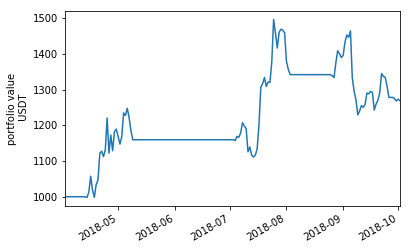

In [8]:
if __name__ == '__main__':
    run_algorithm(
        initialize=initialize,
        capital_base=1000,
        algo_namespace='inside bar',
        handle_data=handle_data,
        analyze=analyze, 
        data_frequency='daily',
        start= pd.to_datetime('2018-04-01', utc=True),
        end= pd.to_datetime('2018-10-01', utc=True),
        exchange_name='bitfinex',
        quote_currency='usdt'
    )